# Difussion equation

Solving the poisson equation $u_t-\Delta u = f$ using a physics informed neural network in multi dim.

### Manufactured solution


We use $u = t\sin (x+y)$ for $x \in X_1\times X_2$, $t\in[t_1,t_2]$ to manufacture the rhs of the difussion equation above.

### Importing packages

In [99]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os

import flowDataProcess

### Manufacturing data for trainig

In [100]:
np.random.seed(123)
pde_data_size = 2000
bc_data_size = 400

#domain range
X_1_domain = [-2, 2]
X_2_domain = [0, 1]
#time range
T_initial = 0
T_final = 1
T_domain = [T_initial, T_final]

#space data
space_dim = 2
X_1_tr_pde = np.random.uniform(X_1_domain[0], X_1_domain[1], pde_data_size).reshape(pde_data_size,1)
X_2_tr_pde = np.random.uniform(X_2_domain[0], X_2_domain[1], pde_data_size).reshape(pde_data_size,1)
# X_tr_pde = np.random.uniform(-1,1,pde_data_size*space_dim).reshape(pde_data_size,space_dim)

#temporal data
X_tr_time = np.random.uniform(T_initial, T_final, pde_data_size).reshape(pde_data_size,1)

X_tr_pde = np.concatenate([X_1_tr_pde, X_2_tr_pde, X_tr_time],axis=1)
X_1_tr_pde.shape

(2000, 1)

In [101]:
X_tr_pde.shape

(2000, 3)

### Looking at the scatter plot of data

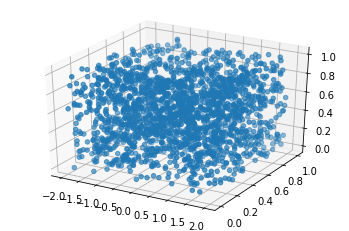

In [102]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tr_pde[:,0],X_tr_pde[:,1],X_tr_pde[:,2])


### Defining the labels(true values) for the training data

In [103]:
Y_tr_pde = np.zeros((X_tr_pde.shape[0],1))
# Y_tr_pde = X_tr_pde[:,0:1]


In [104]:
Y_tr_pde = np.concatenate([Y_tr_pde,np.zeros((Y_tr_pde.shape[0],1))],axis=1)
Y_tr_pde.shape

(2000, 2)

## BC data 

In [105]:
# bc_data_size = 100

X_bc_left = np.random.uniform(X_2_domain[0],X_2_domain[1],
                              bc_data_size).reshape(bc_data_size,1)
X_bc_left = np.concatenate([X_1_domain[0]*np.ones((bc_data_size,1)),
                            X_bc_left], axis=1)
X_bc_left = np.concatenate([X_bc_left,
                            np.random.uniform(T_initial, T_final, bc_data_size).reshape(bc_data_size,1)], 
                            axis=1)

X_bc_bottom = np.random.uniform(X_1_domain[0],X_1_domain[1],
                                bc_data_size).reshape(bc_data_size,1)
X_bc_bottom = np.concatenate([X_bc_bottom, X_2_domain[0]*np.ones((bc_data_size,1))],
                             axis=1)
X_bc_bottom = np.concatenate([X_bc_bottom,
                              np.random.uniform(T_initial, T_final, bc_data_size).reshape(bc_data_size,1)], axis=1)

X_bc_right = np.random.uniform(X_2_domain[0],X_2_domain[1],
                              bc_data_size).reshape(bc_data_size,1)
X_bc_right = np.concatenate([X_1_domain[1]*np.ones((bc_data_size,1)),
                            X_bc_right], axis=1)
X_bc_right = np.concatenate([X_bc_right,
                            np.random.uniform(T_initial, T_final, bc_data_size).reshape(bc_data_size,1)], 
                            axis=1)

X_bc_top = np.random.uniform(X_1_domain[0],X_1_domain[1],
                                bc_data_size).reshape(bc_data_size,1)
X_bc_top = np.concatenate([X_bc_top, X_2_domain[1]*np.ones((bc_data_size,1))],
                          axis=1)
X_bc_top = np.concatenate([X_bc_top,
                            np.random.uniform(T_initial, T_final, bc_data_size).reshape(bc_data_size,1)], 
                            axis=1)

X_bc = np.concatenate([X_bc_left, X_bc_bottom, X_bc_right, X_bc_top],axis=0)

#Add iniital condition below: add them to be X_ic and finallly concatenate bc and ic to get X_bc_ic
X_ic = np.random.uniform(X_1_domain[0],X_1_domain[1],
                                bc_data_size).reshape(bc_data_size,1)
X_ic = np.concatenate([X_ic, np.random.uniform(X_2_domain[0],X_2_domain[1],
                              bc_data_size).reshape(bc_data_size,1)],
                          axis=1)
X_ic = np.concatenate([X_ic,
                            T_initial*np.ones((bc_data_size,1))], 
                            axis=1)

In [106]:
X_bc_ic = np.concatenate([X_bc, X_ic],axis=0)

In [107]:
X_bc_ic

array([[-2.        ,  0.04296696,  0.24703121],
       [-2.        ,  0.28069545,  0.48657334],
       [-2.        ,  0.47581722,  0.76460359],
       ...,
       [-1.4357224 ,  0.98514494,  0.        ],
       [ 1.05569936,  0.22066212,  0.        ],
       [ 0.00442776,  0.61329717,  0.        ]])

In [108]:
Y_bc_ic = np.sin(X_bc_ic[:,0:1] + X_bc_ic[:,1:2]) * X_bc_ic[:,2:3]
# Y_bc = np.concatenate([Y_bc, np.ones((Y_bc.shape[0],1))], axis=1 )

In [109]:
data_processor = Data_preprocess(2, dom_bounds=[X_1_domain,X_2_domain,T_domain], time_dep=True)

In [110]:
X_tr, Y_tr = data_processor.get_training_data(X_bc_ic,Y_bc_ic, X_col_points=pde_data_size)

In [111]:
# X_tr = np.concatenate((X_tr_pde, X_bc), axis=0)
# Y_tr = np.concatenate((Y_tr_pde, Y_bc), axis=0)

## Training the model

In [112]:
from tensorflow.keras import backend as K
class FlowNetModel(tf.keras.Model):

    def __init__(self, space_dim=1, time_dep=False, output_dim=1,
                 n_hid_lay=3, n_hid_nrn=20, act_func = "tanh"):
        super(FlowNetModel, self).__init__()
        
        self.space_dim = space_dim
        self.time_dep = time_dep
        self.output_dim = output_dim
        self.n_hid_lay = n_hid_lay
        self.n_hid_nrn = n_hid_nrn
        
        self.hidden_block = [keras.layers.Dense( self.n_hid_nrn, activation=act_func,
                                           name="dense_"+str(i+1) ) for i in range(n_hid_lay)]
#         self.dense_1 = keras.layers.Dense(20, activation="elu",
#                                           name="dense_1")
#         self.dense_2 = keras.layers.Dense(20, activation="elu",
#                                          name="dense_2")
#         self.dense_3 = keras.layers.Dense(20, activation="elu",
#                                          name="dense_3")
        self.final_layer = keras.layers.Dense(self.output_dim,
                                         name="final_layer")

    def findGrad(self,func,argm):
        try:
            return keras.layers.Lambda(lambda z: [tf.gradients(z[0],x_i,
                                                               unconnected_gradients='zero')
                                                  for x_i in z[1] ]) ([func,argm])
        except Exception as e:
            print("Error occured in finding the time derrivative  lambda layer of type {} as follows: \n{}".format(type(e)),e)
            
    def findTimeDer(self,func,argm):
        try:
            return keras.layers.Lambda(lambda z: tf.gradients(z[0],z[1],
                                                               unconnected_gradients='zero') [0]) ([func,argm])
        except Exception as e:
            print("Error occured in find gradient lambda layer of type {} as follows: \n{} ".format(type(e)),e)
            
            
    def findSecGrad(self,func,argm):
        try:
            # list containng diagonal entries of hessian matrix. Note that  tf.gradients 
            #returns a list of tensors and hence thats why we have  a [0] at the end of  
            #the tf.gradients fucntion as tf.gradients(func,argm) [0]
            del_sq_layer = keras.layers.Lambda( lambda z: [ tf.gradients(z[0][i], z[1][i],
                                                              unconnected_gradients='zero') [0]
                                                  for i in range(len(z[1])) ] ) ([func,argm])
            return sum(del_sq_layer)
                
        except Exception as e:
            print("Error occured in find laplacian lambda layer of type {} as follows: \n{}".format(type(e)),e)
    
    #final layer representing the lhs P(x,t) of PDE P(x,t)=0
    def findPdeLayer(self, laplacian, input_arg, time_der=0):
        try:
            return keras.layers.Lambda(lambda z: z[0] - z[1] - tf.sin(z[2][0]+z[2][1]) - 
                                       2*z[2][2]*tf.sin(z[2][0]+z[2][1])) ([time_der, laplacian, input_arg])
        except Exception as e:
            print("Error occured in finding pde  lambda layer of type {} as follows: \n{}".format(type(e)),e)
    
    
    def call(self, inputs, training=False):
        """
        Note that inputs should always be given as a list with the last element of the list representing the 
        dimension corresponding to time.
        """
        if self.time_dep:
            try:
                assert(len(inputs) > 1)
                input_space = inputs[:-1]
                input_time = inputs[-1]
            except Exception as e:
                print("Error occured while separating spacial and temporal data from inputs,\
                make sure that spacio-temporal data is being used to for training and \
                x=[space_dim1,..,space_dimn,time_dim]. More details on error below:\n", type(e), e)
        else:
            input_space = inputs
        
        #concatening all the input data (space and time dimensions) making it 
        #read to be passed to the hidden layers
        hidden_output = keras.layers.concatenate(inputs) 
        
        #hidden layers
        for layer_id in range(self.n_hid_lay):
            hidden_output = self.hidden_block[layer_id] (hidden_output)
#         layer_1 = self.dense_1(inputs_conc)
#         layer_2 = self.dense_2(layer_1)
#         layer_3 = self.dense_3(layer_2)
        
        #output layer, this is typically the solution function
        output_layer = self.final_layer(hidden_output)
        
        if training:
            #pde specific layers
            if self.time_dep: 
                grad_layer = self.findGrad(output_layer, input_space)
                time_der_layer = self.findTimeDer(output_layer, input_time)
                laplace_layer = self.findSecGrad(grad_layer, input_space)
                pde_layer = self.findPdeLayer(laplace_layer, inputs, time_der_layer)
            else: #if the problem is not time dependent
                grad_layer = self.findGrad(output_layer, input_space)
    #             time_der_layer = self.findTimeDer(output_layer, input_time)
                laplace_layer = self.findSecGrad(grad_layer, input_space)
                pde_layer = self.findPdeLayer(laplace_layer, inputs, 0)

            return output_layer, pde_layer
        
        elif not training:
                return output_layer

    def get_config(self):
        #getting basic config using the parent model class
        base_config = super().get_config()
        return {**base_config, "space_dim": self.space_dim, 
                "time_dep": self.time_dep, "output_dim": self.output_dim,
                 "n_hid_lay": self.n_hid_lay, "n_hid_nrn": self.n_hid_nrn,
                "act_func": self.act_func }
    
    def from_config(self, config, custom_objects):
        super().from_config(config)
        
        

In [113]:
pinn_model = FlowNetModel(space_dim=2, time_dep=True)

In [114]:
#Loss coming from the boundary terms
def u_loss(y_true, y_pred):
#     print("\n\nreached here 1 \n\n\n")
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    u_sq_error = (1/2)*tf.square(y_true_act-y_pred)
#     print("\n\nreached here 2 \n\n\n")
#     print("\nu_loss: ",tf.where(at_boundary, u_sq_error, 0.))
    return tf.where(at_boundary, u_sq_error, 0.)

#Loss coming from the PDE constrain
def pde_loss(y_true, y_pred):
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    #need to change this to just tf.square(y_pred) after pde constrain is added to grad_layer
    pde_sq_error = (1/2)*tf.square(y_pred)
#     print("\npde_loss: ",tf.where(at_boundary,0.,pde_sq_error))
    return tf.where(at_boundary,0.,pde_sq_error)

In [115]:
pinn_model.compile(loss=[u_loss,pde_loss], optimizer="adam")
# pinn_model.compile(loss=u_loss, optimizer=keras.optimizers.SGD(lr=1e-3))

In [116]:
# pinn_model.fit(x=[X_tr[:,0:1], X_tr[:,1:2], X_tr[:,2:3]], y=[Y_tr, Y_tr], epochs=10)
pinn_model.fit(x=X_tr, y=[Y_tr, Y_tr], epochs=10)

Epoch 1/10
125/125 [==============================] - 1s 8ms/step - loss: 0.2433 - output_1_loss: 0.0347 - output_2_loss: 0.2086
Epoch 2/10
125/125 [==============================] - 1s 9ms/step - loss: 0.0423 - output_1_loss: 0.0088 - output_2_loss: 0.0335
Epoch 3/10
125/125 [==============================] - 1s 8ms/step - loss: 0.0196 - output_1_loss: 0.0055 - output_2_loss: 0.0141
Epoch 4/10
125/125 [==============================] - 1s 7ms/step - loss: 0.0102 - output_1_loss: 0.0036 - output_2_loss: 0.0067
Epoch 5/10
125/125 [==============================] - 1s 9ms/step - loss: 0.0071 - output_1_loss: 0.0029 - output_2_loss: 0.0042
Epoch 6/10
125/125 [==============================] - 1s 8ms/step - loss: 0.0054 - output_1_loss: 0.0023 - output_2_loss: 0.0031
Epoch 7/10
125/125 [==============================] - 1s 8ms/step - loss: 0.0042 - output_1_loss: 0.0019 - output_2_loss: 0.0022
Epoch 8/10
125/125 [==============================] - 1s 12ms/step - loss: 0.0034 - output_1_loss

In [85]:
# pinn_model.compile(loss=[u_loss,pde_loss], optimizer=keras.optimizers.SGD(lr=1e-4))
# pinn_model.fit(x=[X_tr[:,0:1], X_tr[:,1:2]], y=[Y_tr, Y_tr], epochs=10)

In [86]:
pinn_model.summary()

Model: "flow_net_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              multiple                  80        
_________________________________________________________________
dense_2 (Dense)              multiple                  420       
_________________________________________________________________
dense_3 (Dense)              multiple                  420       
_________________________________________________________________
final_layer (Dense)          multiple                  21        
Total params: 941
Trainable params: 941
Non-trainable params: 0
_________________________________________________________________


### Testing the model

In [87]:
# X_test_st = np.random.uniform(-0.5,0.5,20*dim_d).reshape(20,dim_d)

In [88]:
#space test data
test_dat_size = 100
X_test_st = np.random.uniform(X_1_domain[0],X_1_domain[1],test_dat_size).reshape(test_dat_size,1)
X_test_st = np.concatenate([X_test_st, np.random.uniform(X_2_domain[0],X_2_domain[1],test_dat_size).reshape(test_dat_size,1)], axis=1)
#temporal test data
X_test_time = np.random.uniform(T_initial,T_final,test_dat_size).reshape(test_dat_size,1)

X_test_st = np.concatenate([X_test_st, X_test_time],axis=1)


In [89]:
X_test_st = data_processor.prepare_input_data(X_test_st)

In [90]:
# Y_test = pinn_model.predict(x=[X_test_st[:,0:1], X_test_st[:,1:2], X_test_st[:,2:3]])
# pinn_model.predict(x=[X_tr[0:40,0:1], X_tr[0:40,1:2], X_tr[0:40,2:3]]) [0]
Y_test = pinn_model.predict(x=X_test_st)
len(Y_test)

100

In [95]:
Y_test_true = np.sin(X_test_st[0] + X_test_st[1]) * X_test_st[2]
Y_eval = np.concatenate([Y_test_true,np.ones((Y_test_true.shape[0],1))], axis=1)

In [96]:
# pinn_model.evaluate(x=[X_test_st[:,0:1], X_test_st[:,1:2]], y= Y_eval)

In [97]:
np.concatenate([Y_test_true, Y_test], axis=1)

array([[ 0.27601219,  0.28492901],
       [ 0.14540243,  0.13141647],
       [-0.38059227, -0.35104716],
       [-0.40799745, -0.37693545],
       [ 0.02298886, -0.05700881],
       [ 0.64894173,  0.6279189 ],
       [ 0.49922989,  0.58196259],
       [-0.11370791, -0.10746352],
       [-0.31794843, -0.2899957 ],
       [-0.87317673, -0.92495829],
       [ 0.80453291,  0.78727895],
       [-0.47175663, -0.42276785],
       [ 0.66300287,  0.64545685],
       [ 0.362959  ,  0.34103942],
       [ 0.68610531,  0.69145024],
       [-0.09642737, -0.08252255],
       [ 0.49248678,  0.56632698],
       [ 0.29811447,  0.29607746],
       [ 0.41634705,  0.39693114],
       [-0.49375492, -0.46406528],
       [-0.69224581, -0.65527385],
       [ 0.08755652,  0.14370267],
       [-0.01084662, -0.04940484],
       [ 0.22713209,  0.22294572],
       [ 0.70514958,  0.68232942],
       [ 0.81659489,  0.80218488],
       [ 0.14756666,  0.12901407],
       [ 0.30966985,  0.29384223],
       [ 0.01019387,

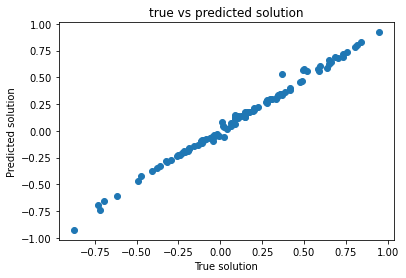

In [98]:
plt.scatter(Y_test_true,Y_test)
plt.title("true vs predicted solution")
plt.xlabel("True solution")
plt.ylabel("Predicted solution")
plt.show()

## Saving and loading the trained FlowNet model

### Saving the model

In [ ]:
os.makedirs("./saved_models", exist_ok=True)

#Saving the model using .h5 extension
pinn_model.save("./save_models/trained_model_1")


In [ ]:
# loaded_model = keras.models.load_model("./save_models/trained_model_1",
#                                       custom_objects={"space_dim": space_dim, 
#                 "time_dep": time_dep, "output_dim": output_dim,
#                  "n_hid_lay": n_hid_lay, "n_hid_nrn": n_hid_nrn,
#                 "act_func": act_func})
loaded_model = keras.models.load_model("./save_models/trained_model_1",
                                      custom_objects={"u_loss": u_loss,
                                                     "pde_loss": pde_loss})

In [ ]:
new_predicted_test=loaded_model.predict(x=[X_test_st[:,0:1], X_test_st[:,1:2], X_test_st[:,2:3]])

In [ ]:
np.concatenate([Y_test,new_predicted_test], axis=1)

In [ ]:
loaded_model.fit(x=[X_tr[:,0:1], X_tr[:,1:2], X_tr[:,2:3]], y=[Y_tr, Y_tr], epochs=1)